# Classifying Audio using Spectrograms and CNNs

## Note on Data locations

I recommend putting the audio (WAV) and image (PNG) files in `data\audio` and `data\iamges` directories, respectively.

The `data\` directory is already included in the `.gitignore` file, and so these large binary files won't be included in commits.

### Example:

<img src="data_structure_example.png" style="widht:400px; height:auto;">

## Imports

In [22]:
import os
import torch
import torchaudio
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
from IPython.display import Audio
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

## AudioFile class

- `file_path`: Path to the audio file
- `file_name`: Name of the audio file (extracted from the path)
- `label`: Label of the audio file (derived from the parent directory name)
- `audio`: Loaded audio data
- `sample_rate`: Sampling rate of the audio file
- `duration`: Duration of the audio file in seconds

### Methods

- `display_waveform()`: Display the waveform of the audio file
- `play()`: Play the audio file and return an audio player widget
- `trim(top_db=30)`: Trim silent parts of the audio using a decibel threshold
- `create_spectrogram()`: Generate a mel spectrogram of the audio file
- `show_spectrogram()`: Display the spectrogram of the audio file
- `save_spectrogram(output_dir=None, skip_existing=True)`: Save the spectrogram as a PNG file


In [7]:
class AudioFile:
    """
    A class to handle audio files and provide utilities for analysis and visualization.

    Attributes:
        file_path (str): Path to the audio file.
        file_name (str): Name of the audio file (extracted from the path).
        label (str): Label of the audio file (derived from the parent directory name).
        audio (np.ndarray): Loaded audio data.
        sample_rate (int): Sampling rate of the audio file.
        duration (float): Duration of the audio file in seconds.
    """

    def __init__(self, file_path):
        """
        Initialize the AudioFile instance by loading the audio file and extracting metadata.

        Args:
            file_path (str): Path to the audio file.
        """
        self.file_path = file_path
        self.file_name = os.path.basename(file_path)
        self.label = os.path.basename(os.path.dirname(self.file_path))
        self.audio, self.sample_rate = librosa.load(file_path)
        self.duration = librosa.get_duration(y=self.audio, sr=self.sample_rate)

    def display_waveform(self):
        """
        Display the waveform of the audio file.
        """
        librosa.display.waveshow(self.audio, sr=self.sample_rate)
        plt.show()
        plt.close()

    def play(self):
        """
        Play the audio file.

        Returns:
            IPython.display.Audio: audio player widget.
        """
        return Audio(self.file_path)

    def trim(self, top_db=30):
        """
        Trim silent parts of the audio based on a decibel threshold.

        Args:
            top_db (int, optional): Decibel threshold below which audio is considered silent. Defaults to 30.
        """
        self.audio, _ = librosa.effects.trim(self.audio, top_db=top_db)

    def create_spectrogram(self):
        """
        Create a mel spectrogram of the audio file.

        Returns:
            np.ndarray: The mel spectrogram in decibel units.
        """
        mel_scale_sgram = librosa.feature.melspectrogram(y=self.audio, sr=self.sample_rate, power=1)
        mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
        return mel_sgram

    def show_spectrogram(self):
        """
        Display the spectrogram of the audio file.
        """
        _spectrogram = self.create_spectrogram()
        librosa.display.specshow(_spectrogram, sr=self.sample_rate, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.show()
        plt.close()

    def save_spectrogram(self, output_dir=None, skip_existing=True):
        """
        Save the spectrogram as a PNG file.

        Args:
            output_dir (str, optional): Directory to save the spectrogram. Defaults to the directory of the audio file.
            skip_existing (bool, optional): Whether to skip saving if the file already exists. Defaults to True.
        """
        if not output_dir:
            output_dir = os.path.dirname(self.file_path)
        else:
            output_dir = os.path.join(output_dir, self.label)

        _base, _ = os.path.splitext(self.file_name)
        output_file = os.path.join(output_dir, _base + ".png")

        if skip_existing and os.path.exists(output_file):
            return

        _spectrogram = self.create_spectrogram()
        librosa.display.specshow(_spectrogram, sr=self.sample_rate)

        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(output_file)
        plt.close()


### Example of using AudioFile class

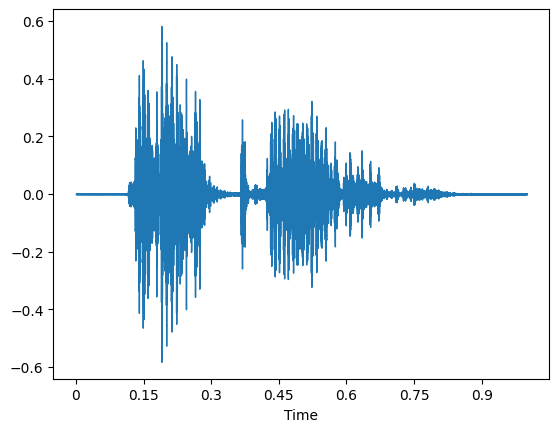

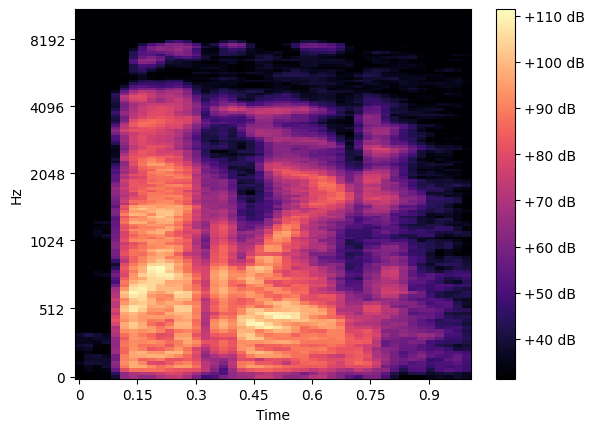

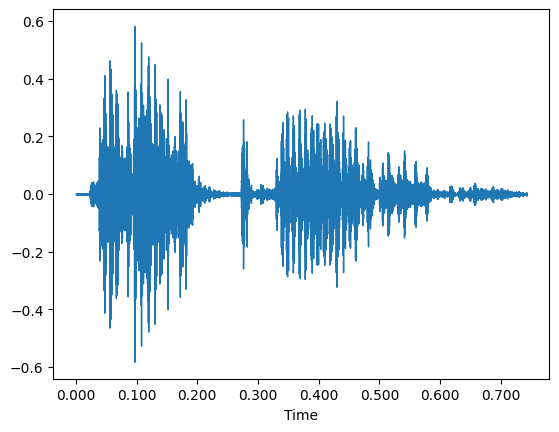

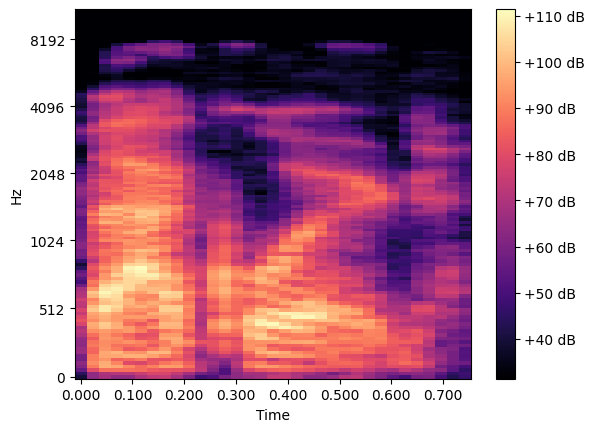

In [8]:
_audio_file = os.path.join("data", "audio", "Speech Commands", "backward", "0a2b400e_nohash_0.wav")
test_audio = AudioFile(_audio_file)

test_audio.display_waveform()
test_audio.show_spectrogram()
test_audio.trim()
test_audio.display_waveform()
test_audio.show_spectrogram()
test_audio.play()   # NOTE: play() has to be in its own cell or the last line; otherwise it doesn't show

## Convert Audio Files to Spectrograms

 - set input_dir and output_dir accordingly
 - call process_directory()
 - if skip_existing is True, existing spectrogram PNG files will be skipped (recommended)


### NOTE:

- Only run this cell if you need to save out all the spectrograms. It takes awhile, and is prone to crashing (hence the use of skip_existing, so it can continue where it left off).
- Commented out the "process_directory(...)" line at the bottom to avoid accidental runs

In [9]:
input_dir = os.path.join("data", "audio","Speech Commands")
output_dir = os.path.join("data", "images", "Speech Commands")

def process_directory(input_dir, output_dir, skip_existing=True):
    for root, dirs, files in os.walk(input_dir):
        # sort directories alphabetically
        dirs.sort()
        print(f"Processing directory: {os.path.basename(root)}")
        for file in files:
            if file.endswith('.wav'):
                # load file
                audio = AudioFile(os.path.join(root, file))
                # save spectrogram
                audio.save_spectrogram(output_dir, skip_existing=skip_existing)


# process_directory(input_dir, output_dir, skip_existing=True)

# Data Pipeline

In [10]:
# Define paths
data_folder='data/audio/Speech Commands'
pd.DataFrame(os.listdir(data_folder),columns=['Files'])

,Files
0,backward
1,bed
2,bird
3,cat
4,dog
5,down
6,eight
7,five
8,follow
9,forward


In [11]:
def count(path):
    size = []
    for file in os.listdir(path):
        size.append(len(os.listdir(os.path.join(path,file))))
    return pd.DataFrame(size,columns=['Number Of Sample'],index=os.listdir(path))  
    
file_counts = count(data_folder)
file_counts

,Number Of Sample
backward,1664
bed,2014
bird,2064
cat,2031
dog,2128
down,3917
eight,3787
five,4052
follow,1579
forward,1557


## Create time series dataset

In [12]:
def create_dataset(path):
    file_paths = []
    data = []
    label = []
    sample = []
    durations = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        for fil in os.listdir(folder_path):
            file_path = os.path.join(folder_path,fil)
            audio_file = AudioFile(file_path)
            audio_data = audio_file.audio
            sample_rate = audio_file.sample_rate
            duration = audio_file.duration
            file_paths.append(file_path)
            data.append(audio_data)
            sample.append(sample_rate)
            label.append(folder)
            durations.append(duration)
    return data,file_paths,label,sample,durations

audio_data,file_paths,label,sample,durations = create_dataset(data_folder)
audio_df = pd.DataFrame()
audio_df['file_paths'], audio_df['Label'], audio_df['sample'], audio_df['duration'] = file_paths,label,sample,durations
audio_df

,file_paths,Label,sample,duration
0,data/audio/Speech Commands\backward\0165e0e8_n...,backward,22050,1.0
1,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.0
2,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.0
3,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.0
4,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.0
...,...,...,...,...
105824,data/audio/Speech Commands\zero\ffd2ba2f_nohas...,zero,22050,1.0
105825,data/audio/Speech Commands\zero\ffd2ba2f_nohas...,zero,22050,1.0
105826,data/audio/Speech Commands\zero\ffd2ba2f_nohas...,zero,22050,1.0
105827,data/audio/Speech Commands\zero\ffd2ba2f_nohas...,zero,22050,1.0


### Create numbered labels

In [13]:
numbered_labels = {}
start = 0
for i in pd.unique(audio_df.Label):
    numbered_labels[i] = start
    start += 1

pd.DataFrame(numbered_labels.values(),columns=['Value'],index=numbered_labels.keys())

,Value
backward,0
bed,1
bird,2
cat,3
dog,4
down,5
eight,6
five,7
follow,8
forward,9


### Label data with numbered labels

In [14]:
audio_df['Numbered Label'] = audio_df['Label'].apply(lambda x: numbered_labels[x]) 

audio_df

,file_paths,Label,sample,duration,Numbered Label
0,data/audio/Speech Commands\backward\0165e0e8_n...,backward,22050,1.0,0
1,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.0,0
2,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.0,0
3,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.0,0
4,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.0,0
...,...,...,...,...,...
105824,data/audio/Speech Commands\zero\ffd2ba2f_nohas...,zero,22050,1.0,34
105825,data/audio/Speech Commands\zero\ffd2ba2f_nohas...,zero,22050,1.0,34
105826,data/audio/Speech Commands\zero\ffd2ba2f_nohas...,zero,22050,1.0,34
105827,data/audio/Speech Commands\zero\ffd2ba2f_nohas...,zero,22050,1.0,34


### Pad the audio data, so each file is the same duration

In [15]:
# Pad the arrays so they are all the same length
audio_data_padded = [
    np.pad(arr, (0, 22050 - len(arr)), mode='constant', constant_values=0)
    for arr in audio_data]

# Create array from list of data arrays
audio_data_arr = np.array(audio_data_padded)

KeyboardInterrupt: 

### Split padded data into train/val/test for baseline model testing

In [16]:
from sklearn.model_selection import train_test_split

# Split indices for train, test, and validation sets
train_idx, test_idx = train_test_split(
    audio_df.index,  # Use DataFrame indices
    test_size=0.2,  # 20% for test
    stratify=audio_df['Numbered Label'],  # Stratify based on the numeric labels
    random_state=42
)

train_idx, val_idx = train_test_split(
    train_idx,  # Split the remaining data
    test_size=0.25,  # 25% of the remaining 80% -> 20% total for validation
    stratify=audio_df.loc[train_idx, 'Numbered Label'],  # Stratify on the training subset
    random_state=42
)

# Convert indices into sets
train_audio = [audio_data_padded[i] for i in train_idx]
val_audio = [audio_data_padded[i] for i in val_idx]
test_audio = [audio_data_padded[i] for i in test_idx]

train_labels = audio_df.loc[train_idx, 'Numbered Label'].values
val_labels = audio_df.loc[val_idx, 'Numbered Label'].values
test_labels = audio_df.loc[test_idx, 'Numbered Label'].values

In [ ]:
# Check class distributions
print("Train class distribution:")
print(pd.Series(train_labels).value_counts(normalize=True))

print("Validation class distribution:")
print(pd.Series(val_labels).value_counts(normalize=True))

print("Test class distribution:")
print(pd.Series(test_labels).value_counts(normalize=True))

Train class distribution:
34    0.038285
7     0.038285
33    0.038207
23    0.037766
18    0.037246
17    0.037167
5     0.037010
21    0.036758
11    0.036663
29    0.036663
26    0.036584
25    0.036474
20    0.036332
15    0.035923
6     0.035781
22    0.035687
19    0.035387
10    0.035230
27    0.035230
30    0.035183
4     0.020111
32    0.020064
13    0.019969
16    0.019843
2     0.019497
12    0.019402
3     0.019198
24    0.019119
1     0.019025
28    0.016615
0     0.015717
31    0.015056
8     0.014914
14    0.014883
9     0.014725
Name: proportion, dtype: float64
Validation class distribution:
34    0.038316
7     0.038316
33    0.038222
23    0.037796
18    0.037230
17    0.037182
5     0.037041
21    0.036757
29    0.036663
11    0.036663
26    0.036615
25    0.036474
20    0.036332
15    0.035907
6     0.035812
22    0.035718
19    0.035387
27    0.035198
10    0.035198
30    0.035151
4     0.020079
32    0.020032
13    0.019938
16    0.019843
2     0.019512
12    0.01

### Extract MFCC's features for baseline models

In [17]:
def extract_mfcc(audio_data, sr=22050, n_mfcc=13):
    features = []
    for data in audio_data:
        mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc)  # Shape: (13, n_frames)

        # Flatten MFCCs to (13 * n_frames,)
        features.append(mfcc.flatten())
    return np.array(features)

# Extract MFCCs
train_mfcc_features = extract_mfcc(train_audio)  # List of (13, n_frames)
val_mfcc_features = extract_mfcc(val_audio)  # List of (13, n_frames)
test_mfcc_features = extract_mfcc(test_audio)  # List of (13, n_frames)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train Logistic Regression
log_reg = LogisticRegression(max_iter=10000, random_state=42)
log_reg.fit(train_mfcc_features, train_labels)

# Evaluate on Validation Set
val_predictions = log_reg.predict(val_mfcc_features)
print("Logistic Regression Validation Accuracy:", accuracy_score(val_labels, val_predictions))
print("Classification Report:")
print(classification_report(val_labels, val_predictions))

# Evaluate on Test Set
test_predictions = log_reg.predict(test_mfcc_features)
print("Logistic Regression Test Accuracy:", accuracy_score(test_labels, test_predictions))

Logistic Regression Validation Accuracy: 0.3917603704053671
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.31      0.32       333
           1       0.29      0.24      0.26       403
           2       0.41      0.46      0.43       413
           3       0.27      0.27      0.27       406
           4       0.25      0.14      0.18       425
           5       0.30      0.27      0.28       784
           6       0.45      0.52      0.48       758
           7       0.35      0.34      0.35       811
           8       0.34      0.35      0.35       316
           9       0.32      0.28      0.30       311
          10       0.38      0.41      0.39       745
          11       0.31      0.29      0.30       776
          12       0.37      0.35      0.36       411
          13       0.49      0.57      0.53       422
          14       0.31      0.27      0.29       315
          15       0.34      0.33      0.33       76

c:\Users\Parker\dev\Dev_School\Capstone\288R_Capstone\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
param_grid = {
    'n_estimators': [5,50, 100, 200, 300, 400, 500],
    'max_depth': [None, 5],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt',]
}

# Perform Grid Search
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(train_mfcc_features, train_labels)

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

# Train the model with best params
best_rf = grid_search.best_estimator_

Fitting 3 folds for each of 14 candidates, totalling 42 fits


In [38]:
# Convert Grid Search results to a DataFrame
cv_results = pd.DataFrame(grid_search.cv_results_)

# Display relevant columns
cv_results = cv_results[
    ['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 
     'mean_test_score', 'std_test_score', 'rank_test_score']
]

# Sort by best rank (lowest rank = best model)
#cv_results = cv_results.sort_values(by="rank_test_score")
cv_results_sorted = cv_results.sort_values(by="mean_test_score", ascending=False)

# Show the 5 worst results
print(cv_results_sorted.head(20))

# Show the top 10 results
cv_results.head(10)

    param_n_estimators param_max_depth  param_min_samples_split  \
1                  500            None                        2   
3                  500            None                        5   
7                  500            None                        2   
9                  500            None                        5   
2                  300            None                        5   
5                  500            None                       10   
0                  300            None                        2   
6                  300            None                        2   
8                  300            None                        5   
19                 500            None                        2   
11                 500            None                       10   
21                 500            None                        5   
27                 500            None                        5   
4                  300            None                       1

,param_n_estimators,param_max_depth,param_min_samples_split,mean_test_score,std_test_score,rank_test_score
0,300,None,2,0.655763,0.003060,7
1,500,None,2,0.664630,0.002175,1
2,300,None,5,0.656252,0.003430,5
3,500,None,5,0.661370,0.003513,2
4,300,None,10,0.650881,0.003618,14
5,500,None,10,0.656141,0.004967,6
6,300,None,2,0.655322,0.003279,8
7,500,None,2,0.661102,0.002500,3
8,300,None,5,0.654850,0.002349,9
9,500,None,5,0.659937,0.002740,4


In [ ]:
import seaborn as sns

plt.figure(figsize=(10,6))

# Loop through different values of max_depth
for depth in sorted(cv_results["param_max_depth"].unique()):
    subset = cv_results[cv_results["param_max_depth"] == depth]
    plt.plot(subset["param_n_estimators"].astype(int), subset["mean_test_score"], marker='o', label=f"max_depth={depth}")

# Labels and title
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Mean Cross-Validation Accuracy")
plt.title("Random Forest Accuracy vs. Number of Trees (Grouped by max_depth)")
plt.legend()
plt.grid()

# Show the plot
plt.show()

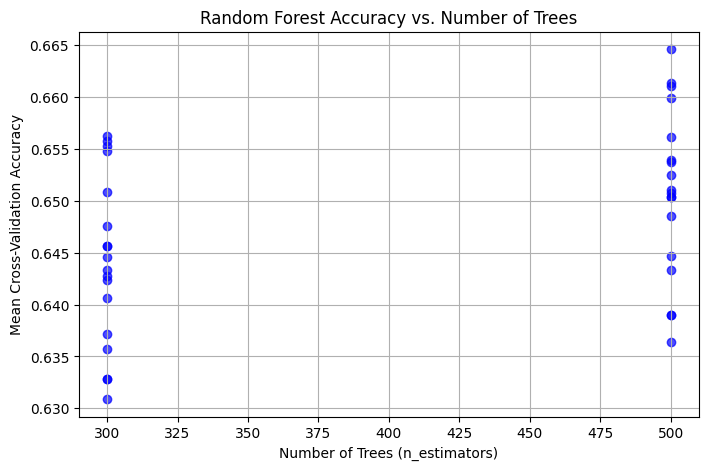

In [39]:
n_estimators = cv_results["param_n_estimators"].astype(int)  # Convert to integer
mean_accuracy = cv_results["mean_test_score"]  # Mean cross-validation accuracy

# Plot the results
plt.figure(figsize=(8,5))
plt.scatter(cv_results["param_n_estimators"], cv_results["mean_test_score"], color='blue', alpha=0.7)

# Labels and title
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Mean Cross-Validation Accuracy")
plt.title("Random Forest Accuracy vs. Number of Trees")
plt.grid()

# Show the plot
plt.show()

In [40]:
print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_
best_rf.fit(train_mfcc_features, train_labels)

# Evaluate on test set
test_predictions = best_rf.predict(test_mfcc_features)
print("Test Accuracy:", accuracy_score(test_labels, test_predictions))

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(train_mfcc_features, train_labels)

# Evaluate on Validation Set
val_predictions = rf.predict(val_mfcc_features)
print("Random Forest Validation Accuracy:", accuracy_score(val_labels, val_predictions))
print("Classification Report:")
print(classification_report(val_labels, val_predictions))

# Evaluate on Test Set
test_predictions = rf.predict(test_mfcc_features)
print("Random Forest Test Accuracy:", accuracy_score(test_labels, test_predictions))

Random Forest Validation Accuracy: 0.6520835301899273
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.56      0.66       333
           1       0.57      0.42      0.48       403
           2       0.62      0.58      0.60       413
           3       0.67      0.41      0.51       406
           4       0.54      0.24      0.33       425
           5       0.51      0.62      0.56       784
           6       0.66      0.85      0.74       758
           7       0.55      0.58      0.56       811
           8       0.70      0.37      0.49       316
           9       0.77      0.32      0.45       311
          10       0.56      0.73      0.64       745
          11       0.49      0.54      0.51       776
          12       0.83      0.67      0.74       411
          13       0.80      0.78      0.79       422
          14       0.68      0.31      0.42       315
          15       0.63      0.61      0.62       760
    

In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
train_mfcc_features_scaled = scaler.fit_transform(train_mfcc_features)
val_mfcc_features_scaled = scaler.transform(val_mfcc_features)
test_mfcc_features_scaled = scaler.transform(test_mfcc_features)

# Use the scaled features in Logistic Regression or SVM
log_reg.fit(train_mfcc_features_scaled, train_labels)
val_predictions = log_reg.predict(val_mfcc_features_scaled)
print("Scaled Logistic Regression Validation Accuracy:", accuracy_score(val_labels, val_predictions))

Scaled Logistic Regression Validation Accuracy: 0.3989889445336861


## Exploratory Data Analysis

In [ ]:
audio_df.shape

(105829, 5)

In [ ]:
def count(path):
    size = []
    for file in os.listdir(path):
        size.append(len(os.listdir(os.path.join(path,file))))
    return pd.DataFrame(size,columns=['Number Of Sample'],index=os.listdir(path))  
    
file_counts = count(data_folder)
file_counts

,Number Of Sample
backward,1664
bed,2014
bird,2064
cat,2031
dog,2128
down,3917
eight,3787
five,4052
follow,1579
forward,1557


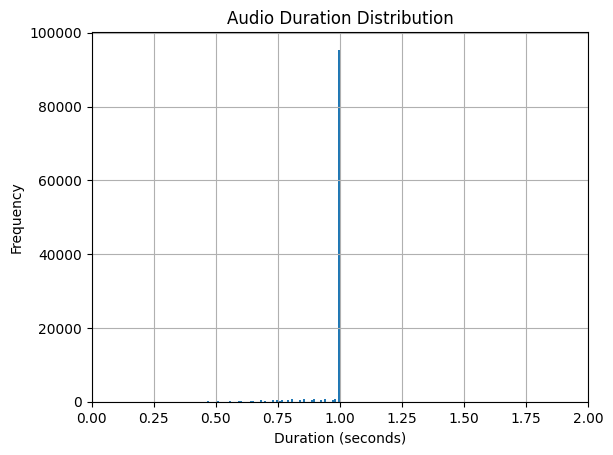

In [ ]:
audio_df["duration"].hist(bins=100)
plt.title("Audio Duration Distribution")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.xlim(0,2)
plt.show()

In [ ]:
# Find how the indeces for files that are less than 1 second
invalid_indices = [i for i, arr in enumerate(audio_data) if len(arr) != 22050]

# Print the # of files less than 1 second
print("# of files less than 1 second:", len(invalid_indices))

# Will put code for padding the data in the data pipeline section

# of files less than 1 second: 10435


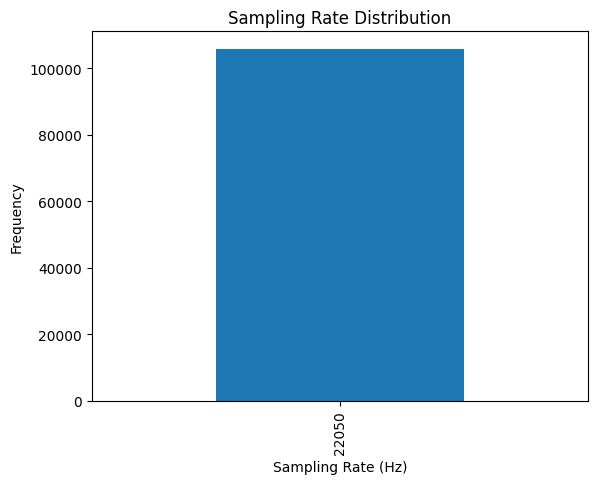

In [ ]:
audio_df["sample"].value_counts().plot(kind="bar")
plt.title("Sampling Rate Distribution")
plt.xlabel("Sampling Rate (Hz)")
plt.ylabel("Frequency")
plt.show()

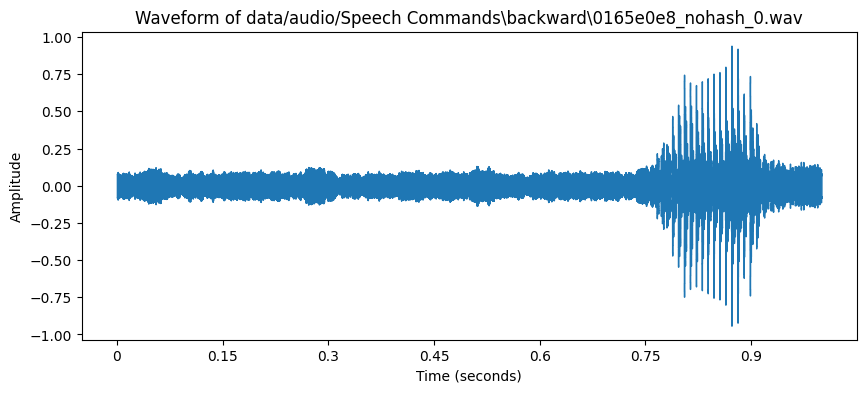

In [ ]:
sample_data = audio_data[0]
sr = audio_df['sample'].iloc[0]
plt.figure(figsize=(10, 4))
librosa.display.waveshow(sample_data, sr=sr)
plt.title(f"Waveform of {audio_df['file_paths'].iloc[0]}")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

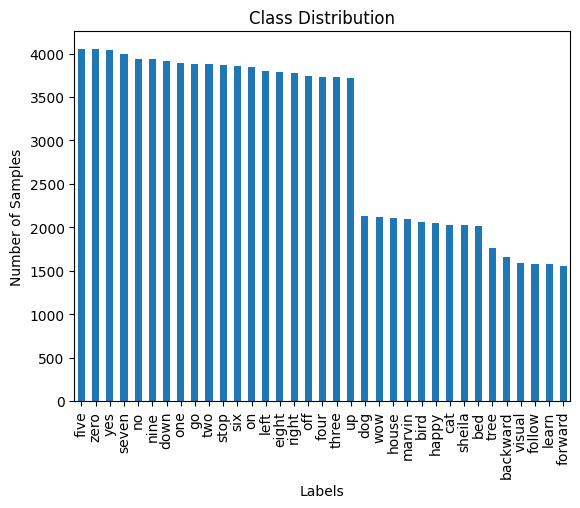

In [ ]:
audio_df["Label"].value_counts().plot(kind="bar")
plt.title("Class Distribution")
plt.xlabel("Labels")
plt.ylabel("Number of Samples")
plt.show()

## Extracting pitch

In [ ]:
## attempting with librosa normalization
sample_data = audio_data[300]
sr = audio_df['sample'].iloc[0]
f0 = librosa.yin(sample_data, fmin=20, fmax=1000)
print(f0)

[177.3951278  137.49835613 140.09827687 139.0197277  138.43823336
 129.29907332 138.56121108 138.48077744 134.89065433 129.39689759
 132.56656903 130.87757378 130.14673414 130.85363706 134.83766241
 135.54150369 130.99816063 102.59798146  50.67302206 311.30507972
 316.53972255  43.93705333 110.51596362 141.10401467 143.10253949
 146.54638248 198.35467903 564.14669279 577.29082135 583.19267874
  99.85516751 101.06464925 101.36201454 100.78375406 100.80875214
 100.99727349  22.1986608   23.36818144  23.34695718  83.7688575
 329.53953722 335.84115446 347.04839799  44.38453243]


In [ ]:
print(np.mean(f0))

168.92215222014883


In [ ]:
## Functions to return pitch and average pitch of sample

def return_pitch(sample_num):
    sample_data = audio_data[sample_num]
    f0 = librosa.yin(sample_data, fmin=20, fmax=1000)
    return f0

def average_pitch(sample_num):
    sample_data = audio_data[sample_num]
    f0 = librosa.yin(sample_data, fmin=20, fmax=1000)
    return np.mean(f0)

In [ ]:
return_pitch(550)

array([ 70.68767483,  21.5542522 ,  50.79981954,  24.95486899,
        25.0326935 ,  51.01065548,  50.24108197,  50.22145004,
        24.86637158,  24.79756127,  24.7613659 ,  49.17792778,
        49.57774168,  50.05980921,  52.23783638,  48.34091461,
        48.62269542,  49.23782774,  49.6093606 ,  48.859958  ,
        52.67212496, 220.55702361, 202.86583925, 192.26740105,
       185.081117  , 183.28786547, 191.42396584, 214.01867134,
       212.07096207, 209.74221498, 206.75472163, 203.419273  ,
       198.96395319, 183.66986107,  50.02493403,  50.78274063,
       824.91289699,  25.40450473,  53.01161494, 193.85270763,
       168.9341857 , 165.00100855, 164.15119106])

In [ ]:
print(average_pitch(550))

121.33773594067719


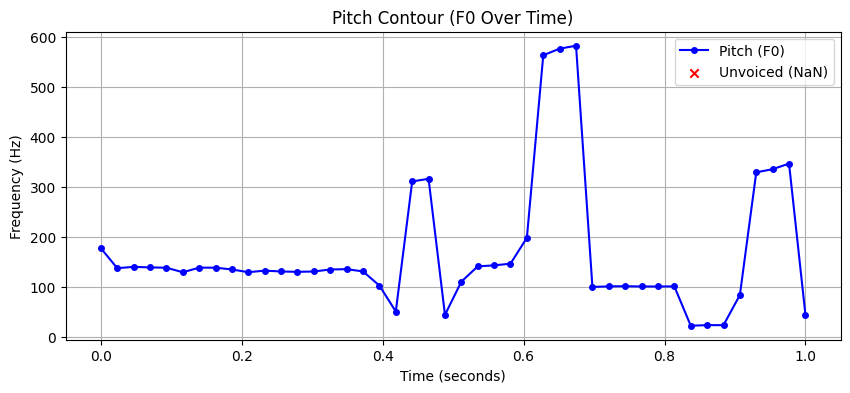

In [ ]:
# Compute time axis for f0
times = np.linspace(0, len(sample_data) / sr, num=len(f0))

# Plot the pitch contour
plt.figure(figsize=(10, 4))
plt.plot(times, f0, label="Pitch (F0)", color="blue", marker="o", markersize=4, linestyle="-")

# Mark unvoiced frames (NaN values in f0)
plt.scatter(times[np.isnan(f0)], np.zeros_like(times[np.isnan(f0)]), color='red', label="Unvoiced (NaN)", marker="x")

# Labels
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.title("Pitch Contour (F0 Over Time)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# trying different audio sample
sample_data2 = audio_data[60000]
f0 = librosa.yin(sample_data2, fmin=20, fmax=1000)
print(f0)
print(audio_df.iloc[60000])

[632.32426435 782.60298837 115.47280357 101.89753663  64.94259065
  25.91322028 105.61195898 433.09438071 157.279593    61.69782006
 122.25969716 120.13403592 118.60051595 117.91859384 116.19508998
 114.32671194 112.49367688 110.52018743 108.4629966  107.05929796
 106.8393759  107.43598741 112.29251869 123.12863936  32.66466266
 114.88501601  33.9777374   34.45171432 100.65058993  41.71975798
 297.55414361  24.86789683  46.4501533  122.52939285  69.98524968
 165.83737519 164.12862678 277.33325512  78.14151299  47.91151593
 306.41100446 151.93707076  23.68443129  23.7578789 ]
file_paths        data/audio/Speech Commands\one\226537ab_nohash...
Label                                                           one
sample                                                        22050
duration                                                        1.0
Numbered Label                                                   21
Name: 60000, dtype: object


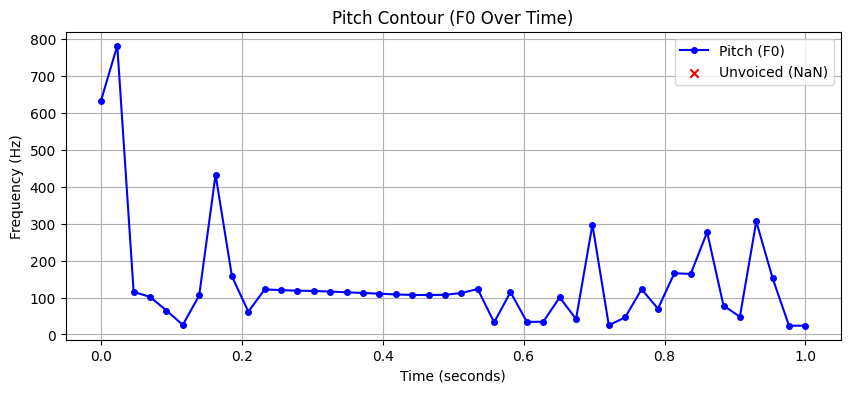

In [ ]:
# Compute time axis for f0
times = np.linspace(0, len(sample_data2) / sr, num=len(f0))

# Plot the pitch contour
plt.figure(figsize=(10, 4))
plt.plot(times, f0, label="Pitch (F0)", color="blue", marker="o", markersize=4, linestyle="-")

# Mark unvoiced frames (NaN values in f0)
plt.scatter(times[np.isnan(f0)], np.zeros_like(times[np.isnan(f0)]), color='red', label="Unvoiced (NaN)", marker="x")

# Labels 
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.title("Pitch Contour (F0 Over Time)")
plt.legend()
plt.grid()
plt.show()

## Extracting pitch statistics across dataset

In [ ]:
dataset_path = r"data\audio\Speech Commands"
# List to store pitch data
pitch_data = []

# Iterate through each word directory
for word in os.listdir(dataset_path):
    word_path = os.path.join(dataset_path, word)
    
    # Check if it's a directory (i.e., a class)
    if os.path.isdir(word_path):
        # Iterate through audio files in the word directory
        for file in os.listdir(word_path):
            if file.endswith(".wav"):
                file_path = os.path.join(word_path, file)
                
                # Load the audio file
                y, sr = librosa.load(file_path, sr=None)
                
                # Compute pitch (F0) using YIN
                # Can change fmin to lower value and fmax to higher value
                f0 = librosa.yin(y, fmin=50, fmax=500)

                # Remove NaNs (unvoiced regions)
                f0 = f0[~np.isnan(f0)]
                
                if len(f0) > 0:  # Only consider files where pitch was detected
                    pitch_data.append({
                        "word": word,
                        "file": file,
                        "mean_f0": np.mean(f0),
                        "median_f0": np.median(f0),
                        "std_f0": np.std(f0),
                        "min_f0": np.min(f0),
                        "max_f0": np.max(f0)
                    })

In [ ]:
# Convert to Pandas DataFrame
pitch_df = pd.DataFrame(pitch_data)

# Save to CSV for further analysis
pitch_df.to_csv("pitch_statistics.csv", index=False)

# Display first few rows
print(pitch_df.head())

       word                   file     mean_f0   median_f0      std_f0  \
0  backward  0165e0e8_nohash_0.wav  137.148522   88.974426   81.460232   
1  backward  017c4098_nohash_0.wav  144.911786  119.826446  104.334736   
2  backward  017c4098_nohash_1.wav  141.948204  111.207695  109.615286   
3  backward  017c4098_nohash_2.wav  169.122299  118.557587  118.709701   
4  backward  017c4098_nohash_3.wav  154.573500  146.064696  104.684598   

      min_f0      max_f0  
0  61.079097  409.261369  
1  53.170360  447.479939  
2  50.763738  478.063368  
3  50.990918  501.136364  
4  53.892310  437.991516  


In [ ]:
## Visualizing the pitch statistics

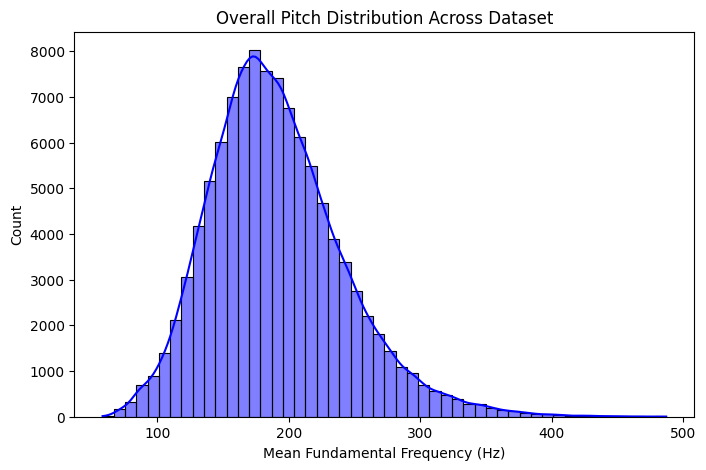

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(pitch_df["mean_f0"], bins=50, kde=True, color="blue")
plt.xlabel("Mean Fundamental Frequency (Hz)")
plt.ylabel("Count")
plt.title("Overall Pitch Distribution Across Dataset")
plt.show()

In general, the fundamental frequency of the complex speech tone – also known as the pitch or f0 – lies in the range of 100-120 Hz for men, but variations outside this range can occur. The f0 for women is found approximately one octave higher. For children, f0 is around 300 Hz.

https://www.dpamicrophones.com/mic-university/background-knowledge/facts-about-speech-intelligibility/#:~:text=In%20general%2C%20the%20fundamental%20frequency,f0%20is%20around%20300%20Hz.

Our dataset follows this general distrubtion of pitch 

In [ ]:
## pitch distribution per word

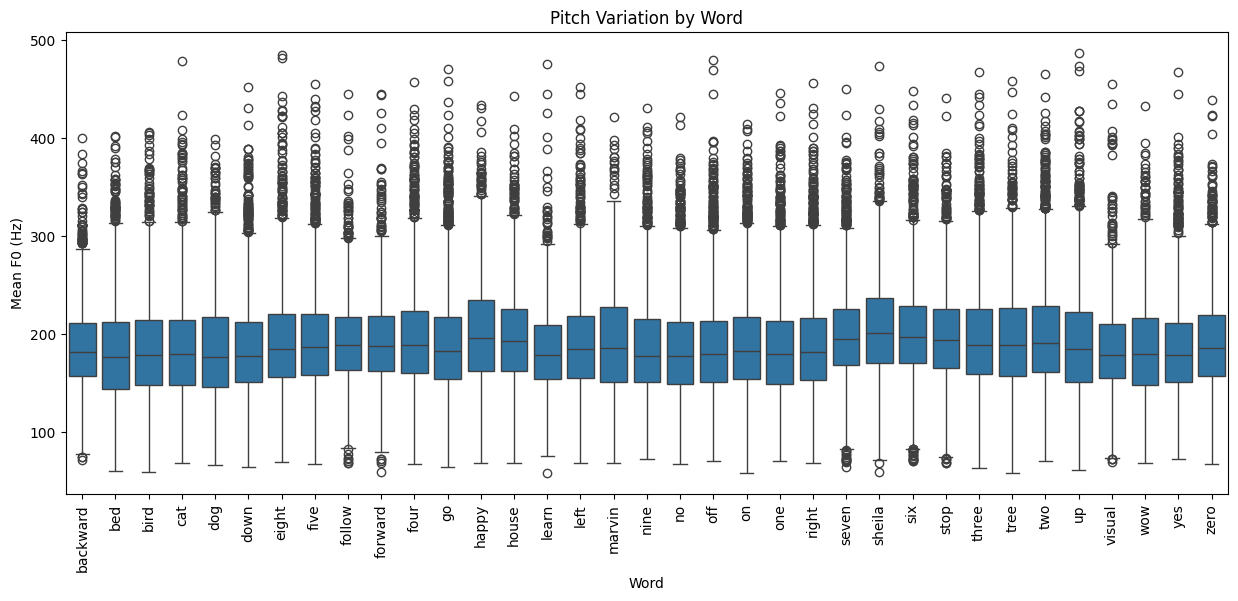

In [ ]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=pitch_df, x="word", y="mean_f0")
plt.xticks(rotation=90)
plt.xlabel("Word")
plt.ylabel("Mean F0 (Hz)")
plt.title("Pitch Variation by Word")
plt.show()

In [ ]:
## Density of Pitch per word

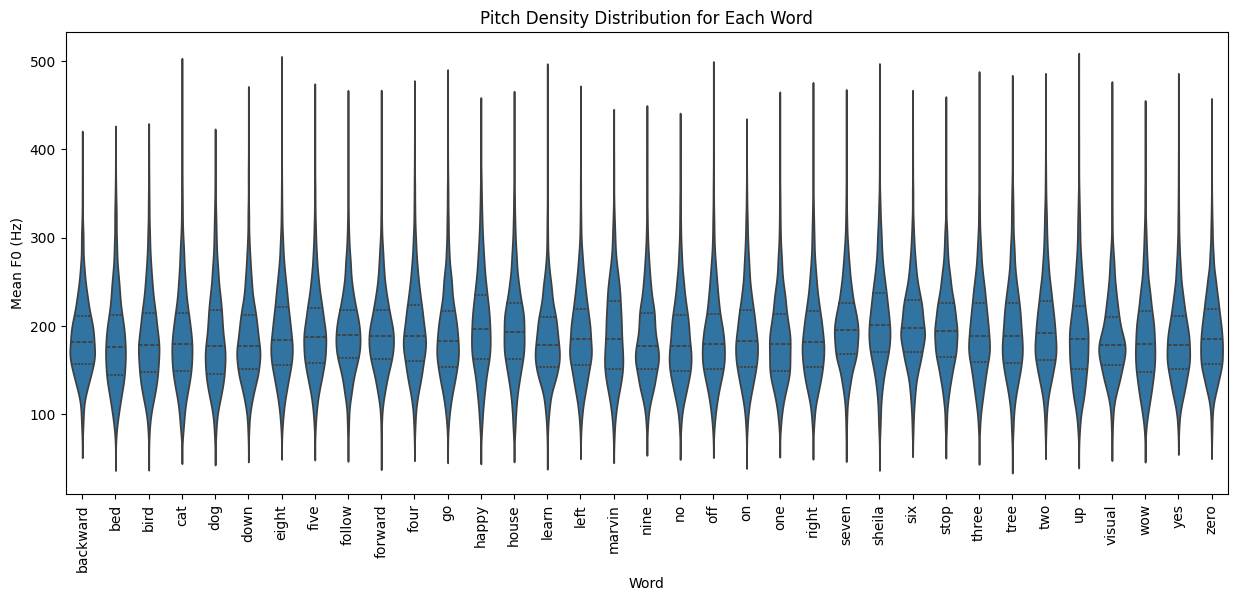

In [ ]:
plt.figure(figsize=(15, 6))
sns.violinplot(data=pitch_df, x="word", y="mean_f0", inner="quartile")
plt.xticks(rotation=90)
plt.xlabel("Word")
plt.ylabel("Mean F0 (Hz)")
plt.title("Pitch Density Distribution for Each Word")
plt.show()

C:\Users\Parker\AppData\Local\Temp\ipykernel_25428\234779674.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_avg_pitch.index, y=word_avg_pitch.values, palette="coolwarm")


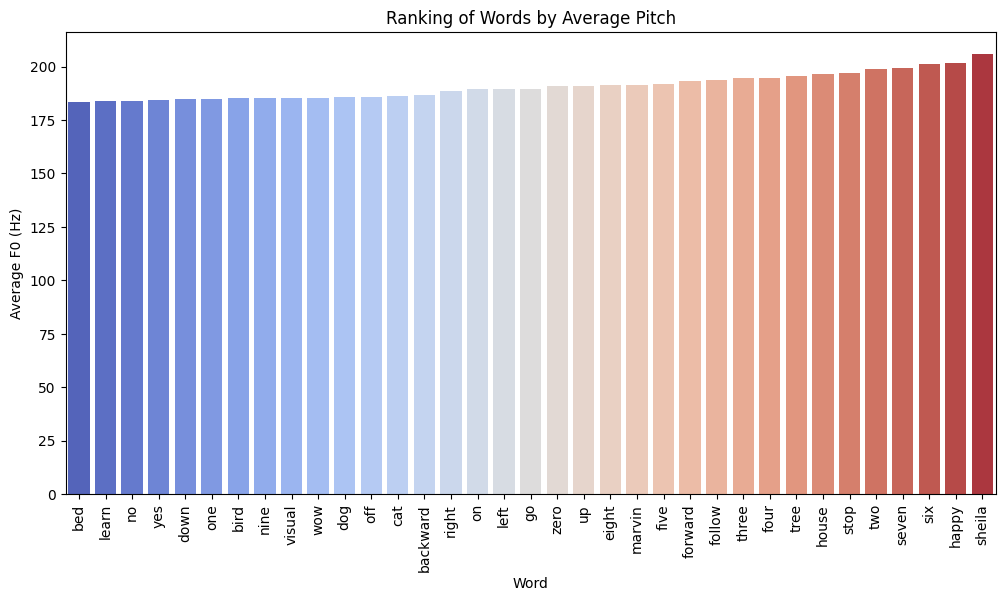

In [ ]:
# Sort words by average pitch
word_avg_pitch = pitch_df.groupby("word")["mean_f0"].mean().sort_values()

# Make the plot
plt.figure(figsize=(12, 6))
sns.barplot(x=word_avg_pitch.index, y=word_avg_pitch.values, palette="coolwarm")
plt.xticks(rotation=90)
plt.xlabel("Word")
plt.ylabel("Average F0 (Hz)")
plt.title("Ranking of Words by Average Pitch")
plt.show()

C:\Users\Parker\AppData\Local\Temp\ipykernel_25428\2452879583.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_std_pitch.index, y=word_std_pitch.values, palette="viridis")


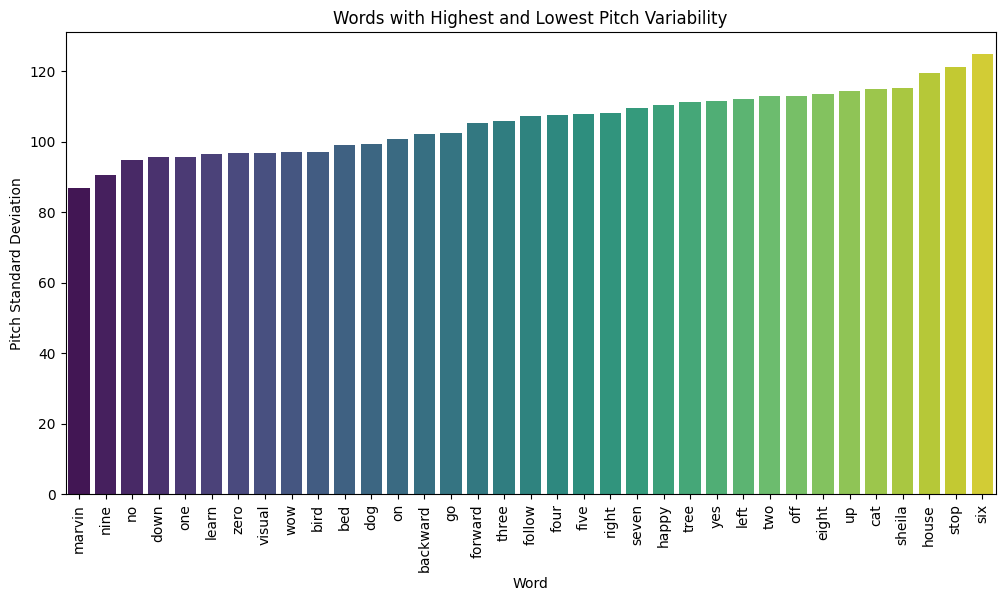

In [ ]:
word_std_pitch = pitch_df.groupby("word")["std_f0"].mean().sort_values()

plt.figure(figsize=(12, 6))
sns.barplot(x=word_std_pitch.index, y=word_std_pitch.values, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("Word")
plt.ylabel("Pitch Standard Deviation")
plt.title("Words with Highest and Lowest Pitch Variability")
plt.show()

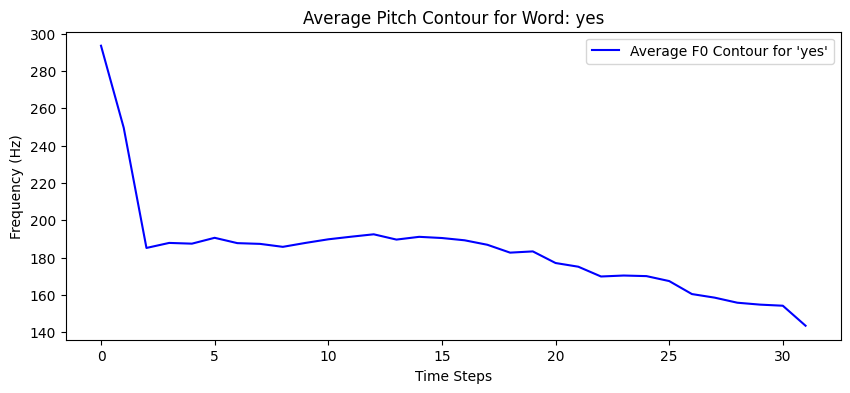

In [ ]:
# word to analyze
target_word = "yes"

# Extract pitch sequences 
word_files = pitch_df[pitch_df["word"] == target_word]["file"]

all_f0_curves = []

for file in word_files:
    file_path = os.path.join(dataset_path, target_word, file)
    y, sr = librosa.load(file_path, sr=None)
    f0 = librosa.yin(y, fmin=50, fmax=500)
    f0 = f0[~np.isnan(f0)]  # Remove NaNs
    all_f0_curves.append(f0)

# Compute mean pitch contour
max_len = max(len(f) for f in all_f0_curves)
aligned_f0 = np.array([np.pad(f, (0, max_len - len(f)), mode='constant', constant_values=np.nan) for f in all_f0_curves])
mean_f0_contour = np.nanmean(aligned_f0, axis=0)

# Plot the mean pitch contour
plt.figure(figsize=(10, 4))
plt.plot(mean_f0_contour, label=f"Average F0 Contour for '{target_word}'", color="blue")
plt.xlabel("Time Steps")
plt.ylabel("Frequency (Hz)")
plt.title(f"Average Pitch Contour for Word: {target_word}")
plt.legend()
plt.show()


## Zero crossing rate

In [ ]:
sample_data = audio_data[50000]
print(audio_df['file_paths'].iloc[50000])

zcr = librosa.feature.zero_crossing_rate(sample_data)

zcr

data/audio/Speech Commands\no\879a2b38_nohash_2.wav


array([[0.01513672, 0.02636719, 0.07177734, 0.12304688, 0.14599609,
        0.15673828, 0.11669922, 0.07666016, 0.05859375, 0.04931641,
        0.06542969, 0.05761719, 0.04882812, 0.04003906, 0.02246094,
        0.01660156, 0.01611328, 0.01660156, 0.02441406, 0.03808594,
        0.04980469, 0.05908203, 0.06201172, 0.05566406, 0.05078125,
        0.04589844, 0.03857422, 0.03613281, 0.03369141, 0.03173828,
        0.03125   , 0.02978516, 0.03369141, 0.04248047, 0.04296875,
        0.04150391, 0.03320312, 0.02148438, 0.02978516, 0.03173828,
        0.03808594, 0.03857422, 0.02197266, 0.01464844]])

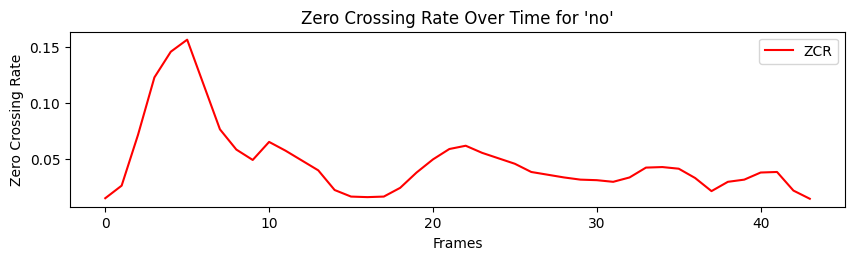

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 2)
plt.plot(zcr[0], label="ZCR", color="red")
plt.xlabel("Frames")
plt.ylabel("Zero Crossing Rate")
plt.title("Zero Crossing Rate Over Time for 'no'")
plt.legend()
plt.show()

In [ ]:
sample_data = audio_data[70000]
print(audio_df['file_paths'].iloc[70000])

zcr = librosa.feature.zero_crossing_rate(sample_data)

zcr

data/audio/Speech Commands\seven\b7e9f841_nohash_0.wav


array([[0.12451172, 0.18212891, 0.25292969, 0.22802734, 0.19628906,
        0.15429688, 0.11181641, 0.08105469, 0.05419922, 0.10205078,
        0.12988281, 0.1796875 , 0.29541016, 0.34130859, 0.40966797,
        0.48535156, 0.49707031, 0.52246094, 0.52929688, 0.5234375 ,
        0.44873047, 0.33740234, 0.25195312, 0.16601562, 0.14794922,
        0.15380859, 0.14355469, 0.13476562, 0.11962891, 0.11962891,
        0.10253906, 0.10693359, 0.10595703, 0.09960938, 0.11669922,
        0.12255859, 0.14257812, 0.16845703, 0.18164062, 0.16503906,
        0.14355469, 0.12451172, 0.07666016, 0.05371094]])

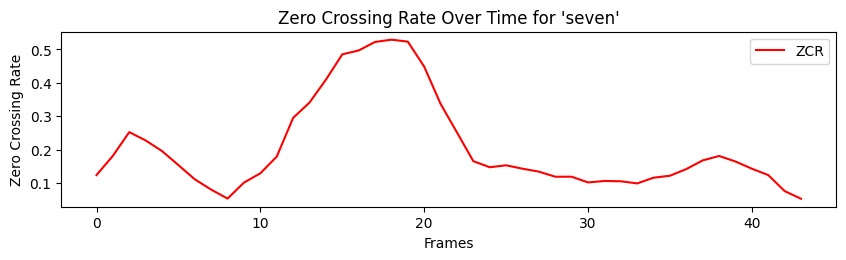

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 2)
plt.plot(zcr[0], label="ZCR", color="red")
plt.xlabel("Frames")
plt.ylabel("Zero Crossing Rate")
plt.title("Zero Crossing Rate Over Time for 'seven'")
plt.legend()
plt.show()

In [ ]:
audio_data_arr = np.array(audio_data_padded)
type(audio_data_arr)

numpy.ndarray

In [ ]:
inertia = []
K_range = range(1, 11)  # Test for k=1 to k=10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(audio_data_arr)
    inertia.append(kmeans.inertia_)

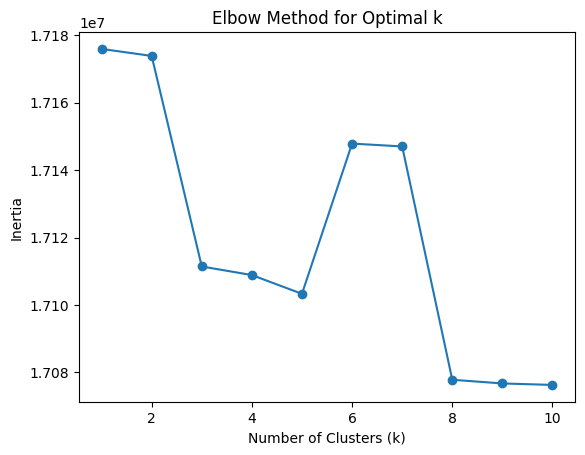

In [ ]:
plt.plot(K_range, inertia, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

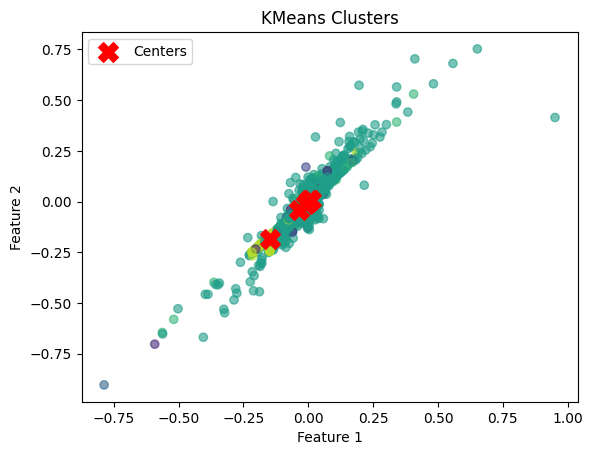

In [ ]:
labels = kmeans.labels_
centers = kmeans.cluster_centers_
plt.scatter(audio_data_arr[:, 0], audio_data_arr[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X', label="Centers")
plt.title("KMeans Clusters")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [ ]:
all_mfcc_features = []
for data in audio_data_padded:
    mfcc = librosa.feature.mfcc(y=data, sr=22050, n_mfcc=13)
    all_mfcc_features.append(mfcc.T)
    
mfcc_features = np.vstack(all_mfcc_features)
print("Combined MFCC Features Shape:", all_mfcc_features.shape)

Combined MFCC Features Shape: (4656476, 13)


In [ ]:
inertia = []
K_range = range(55, 105, 10)  

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(audio_data_arr)
    inertia.append(kmeans.inertia_)
    print(f'kmeans done with clusters {k}')

kmeans done with clusters 55
kmeans done with clusters 65
kmeans done with clusters 75
kmeans done with clusters 85
kmeans done with clusters 95


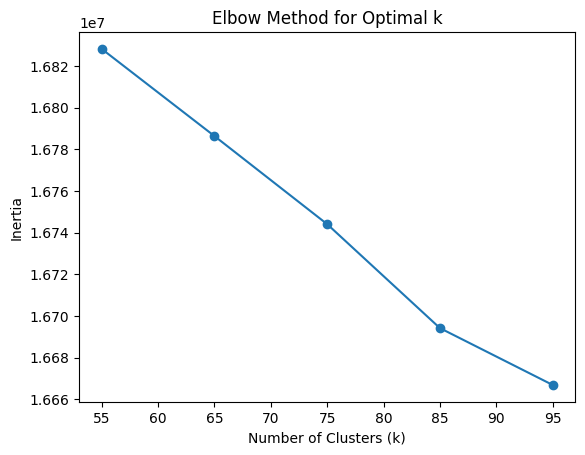

In [ ]:
plt.plot(K_range, inertia, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=85, random_state=42)
kmeans.fit(audio_data_arr)

KMeans(n_clusters=85, random_state=42)

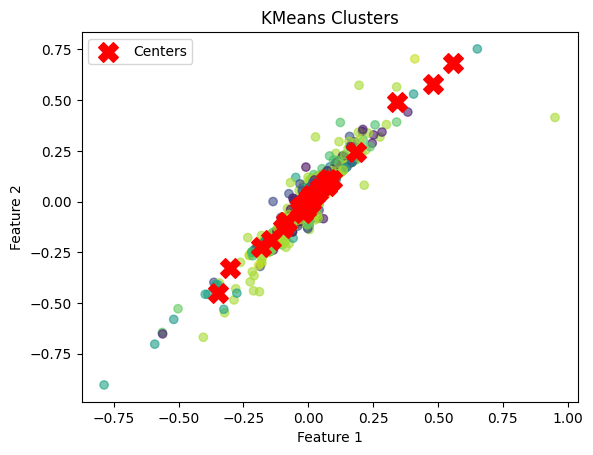

In [ ]:
labels = kmeans.labels_
centers = kmeans.cluster_centers_
plt.scatter(audio_data_arr[:, 0], audio_data_arr[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X', label="Centers")
plt.title("KMeans Clusters")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [ ]:
inertia = []
K_range = range(5, 50, 10)  

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(all_mfcc_features)
    inertia.append(kmeans.inertia_)
    print(f'kmeans done with clusters {k}')

kmeans done with clusters 5
kmeans done with clusters 15
kmeans done with clusters 25
kmeans done with clusters 35
kmeans done with clusters 45


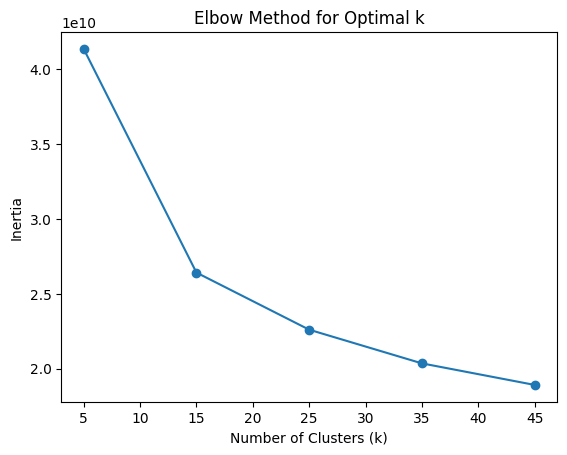

In [ ]:
plt.plot(K_range, inertia, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=15, random_state=42)
kmeans.fit(all_mfcc_features)

KMeans(n_clusters=15, random_state=42)

c:\Users\Parker\dev\Dev_School\Capstone\288R_Capstone\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


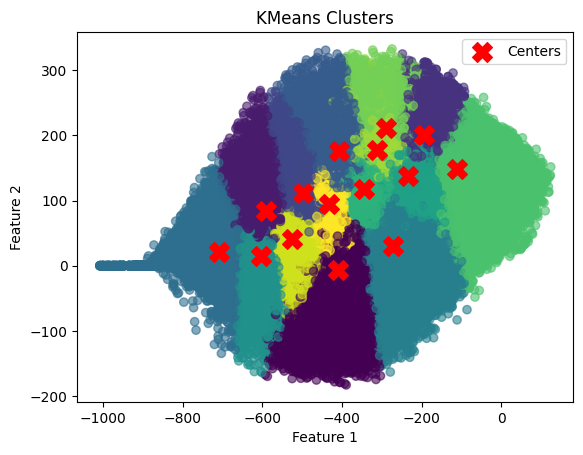

In [ ]:
labels = kmeans.labels_
centers = kmeans.cluster_centers_
plt.scatter(all_mfcc_features[:, 0], all_mfcc_features[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X', label="Centers")
plt.title("KMeans Clusters")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
mfcc_reduced = pca.fit_transform(all_mfcc_features)

# Plot the clusters
plt.scatter(mfcc_reduced[:, 0], mfcc_reduced[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.title("KMeans Clusters of MFCCs")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()